In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf

USE_GPU = True

dtype = torch.float64 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
print('using device:', device)

using device: cpu


In [ ]:
pip install numpy==1.24.3

Note: you may need to restart the kernel to use updated packages.


## American Option Pricing with Multiple Neural Networks (method 1) article [1]
Here I'll try a simple implementation of the method I of the first article :

Here we have constant interest rate so the discount factor is $\exp(-rT)$, and the stock dynamics are modelled with Geometric Brownian Motion (GBM).

$\large dS_t = rS_tdt+\sigma S_tdW_t$

Let's simulate this GBM process by simulating variables of the natural logarithm process of the stock price $x_t = ln(S_t)$, which is normally distributed. For the dynamics of the natural logarithm process of stock prices under GBM model you need to use Ito's calculus.
$\large dx_t = \nu dt+\sigma dW_t ,  \nu = r - \frac{1}{2} \sigma ^ 2$

We can then discretize the Stochastic Differential Equation (SDE) by changing the infinitesimals $dx, dt, dz$ into small steps $\Delta x, \Delta t, \Delta W$.

$\large \Delta x = \nu  \Delta t+\sigma \Delta W$

This is the exact solution to the SDE and involves no approximation.

$\large x_{t+\Delta t} = x_{t} + \nu (\Delta t)+\sigma (W_{t+\Delta t}- W_t)$

In terms of the stock price S, we have:

$\large S_{t+\Delta t} = S_{t} \exp( \nu \Delta t + \sigma (W_{t+\Delta t}- W_t) )$

Where $(W_{t+\Delta t}- W_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$


\\


In [ ]:
def pay_off(S,r,K,dt):
  return torch.maximum(K- S,torch.zeros_like(S))

def simulate_path(M, T, n, r, vol, S, K, dt): #we have to optimize this function with cumsums and so, because we'll have a problem for multi dimensionnal assets!!
    nudt = (r - 0.5 * vol**2) * dt
    lnS = np.log(S)

    # Méthode de Monte Carlo
    Z = np.random.normal(size=(M,n))
    dW=np.sqrt(dt) * Z  #it's the simulation of the dWt_i we'll need in each iteration
    delta_lnSt = nudt + vol*dW
    LnS_s = np.zeros([M, n + 1])

    for i in range(M):
        LnS_s[i, 0] = lnS
        for j in range(1, n + 1):
            LnS_s[i, j] = LnS_s[i, j - 1] + delta_lnSt[i,j - 1]

    S = np.exp(LnS_s)
    S_tensor = torch.tensor(S, device = device ,dtype=dtype)
    dW_tensor = torch.tensor(dW, device = device ,dtype=dtype)


    return S_tensor,dW_tensor


def simulate_paths_(M, T, n, r, vol, S, K, dt):
    nudt = (r - 0.5 * vol**2) * dt
    lnS = np.log(S)

    # Méthode de Monte Carlo
    Z = np.random.normal(size=(M,n))
    dW=np.sqrt(dt) * Z  #it's the simulation of the dWt_i we'll need in each iteration
    delta_lnSt = nudt + vol*dW

    LnS_s = np.zeros([M, n + 1])

    # Set the initial values
    LnS_s[:, 0] = lnS
    # Compute cumulative sums using cumsum
    LnS_s[:, 1:] = np.cumsum(delta_lnSt, axis=1)
    LnS_s[:,1:] +=lnS


    X = np.exp(LnS_s)
    return X, dW

#Parametres

T = 1
n=50
dt = T/n  #les t_i seront donc les i*dt.


S = 36          # Prix de l'action
K = 40           # Prix d'exercice
vol = 0.2       # Volatilité (%)
r = 0.06            # Taux sans risque (%)
M = 10000  # Nombre de simulations

#torch.tensor(S, device = device ,dtype=dtype)



S,dW=simulate_path(M, T, n, r, vol, S, K, dt)
X=torch.zeros([M,n+1], device = device ,dtype=dtype)
Y=torch.zeros_like(X, device = device ,dtype=dtype)


X[ :, n]=pay_off(S[:,n],r,K,dt)
Y[ :, n]=X[ :, n]

beta_dt=math.exp(-r*dt)



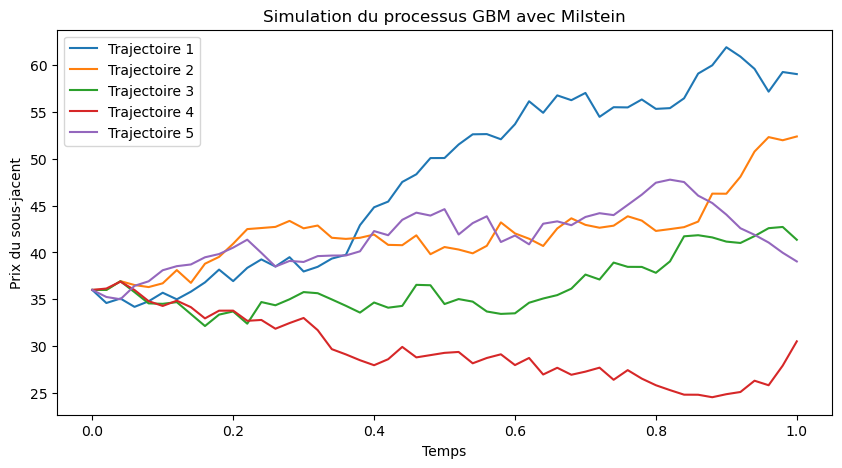

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

def simulate_path_milstein(M, T, n, r, vol, S0):

    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # Use GPU if available, else CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize price matrix
    S = torch.full((M, n+1), S0, dtype=torch.float64, device=device)

    # Generate random normal increments
    Z = torch.randn((M, n), dtype=torch.float64, device=device)
    dW = sqrt_dt * Z  

    for t in range(n):
        S_t = S[:, t]
        dS = S_t * (r * dt + vol * dW[:, t] + 0.5 * vol**2 * (dW[:, t]**2 - dt))
        S[:, t+1] = S_t + dS 

    return S.cpu(), dW.cpu()

#parameters
M, T, n, r, vol, S0 = 10000, 1, 50, 0.06, 0.2, 36  

S_fixed, dW_fixed = simulate_path_milstein(M, T, n, r, vol, S0)

plt.figure(figsize=(10, 5))
for i in range(5):  
    plt.plot(np.linspace(0, T, n+1), S_fixed[i].numpy(), label=f'Trajectoire {i+1}')

plt.xlabel("Temps")
plt.ylabel("Prix du sous-jacent")
plt.title("Simulation du processus GBM avec Milstein")
plt.legend()
plt.show()

**Comparison Euler/Milstein**

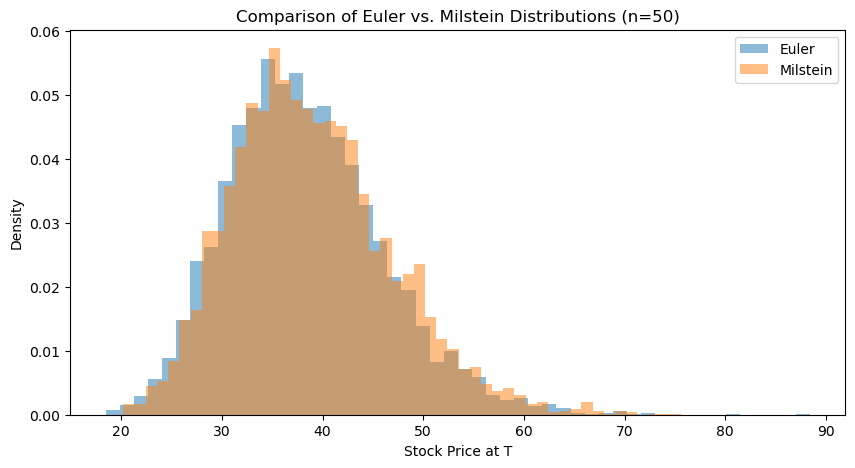

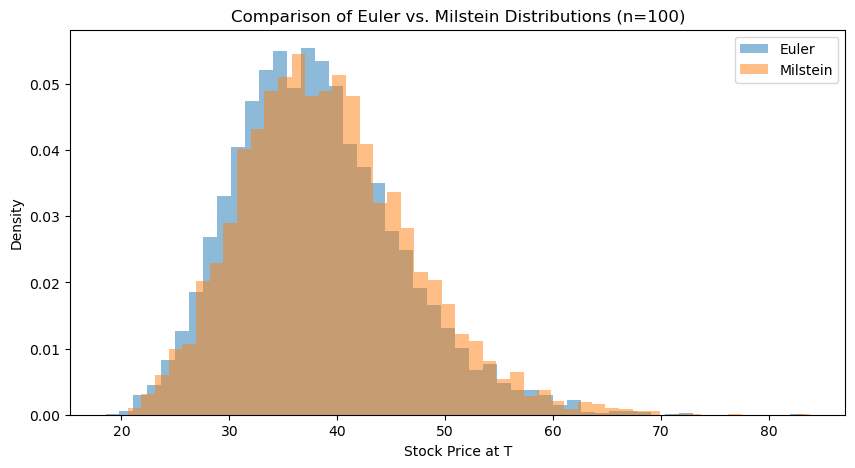

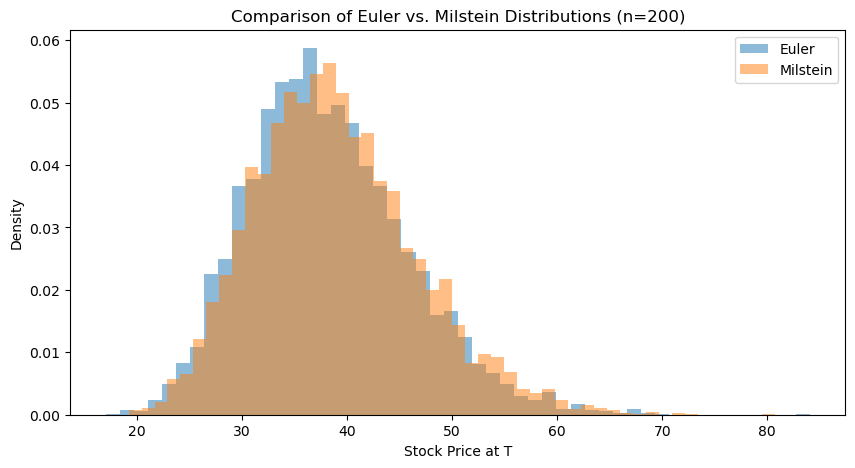


Comparison for n = 50:
Euler:    Mean = 38.2647, Std Dev = 7.7508, Time = 0.0283 sec
Milstein: Mean = 38.9983, Std Dev = 7.9061, Time = 0.0055 sec

Comparison for n = 100:
Euler:    Mean = 38.1541, Std Dev = 7.6639, Time = 0.0111 sec
Milstein: Mean = 39.1417, Std Dev = 7.8830, Time = 0.0164 sec

Comparison for n = 200:
Euler:    Mean = 38.1264, Std Dev = 7.6312, Time = 0.0217 sec
Milstein: Mean = 38.9236, Std Dev = 7.7753, Time = 0.0287 sec


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

# Parameters
M, T, r, vol, S0 = 5000, 1, 0.06, 0.2, 36
n_values = [50, 100, 200]  # Different time step values for comparison

device = "cuda" if torch.cuda.is_available() else "cpu"

def simulate_path_euler(M, T, n, r, vol, S0):
    dt = T / n
    sqrt_dt = np.sqrt(dt)
    S = torch.full((M, n+1), S0, dtype=torch.float64, device=device)
    Z = torch.randn((M, n), dtype=torch.float64, device=device)
    dW = sqrt_dt * Z

    for t in range(n):
        S[:, t+1] = S[:, t] * (1 + r * dt + vol * dW[:, t])

    return S.cpu()

def simulate_path_milstein(M, T, n, r, vol, S0):
    dt = T / n
    sqrt_dt = np.sqrt(dt)
    S = torch.full((M, n+1), S0, dtype=torch.float64, device=device)
    Z = torch.randn((M, n), dtype=torch.float64, device=device)
    dW = sqrt_dt * Z

    for t in range(n):
        S_t = S[:, t]
        dS = S_t * (r * dt + vol * dW[:, t] + 0.5 * vol**2 * dW[:, t]**2)
        S[:, t+1] = S_t + dS

    return S.cpu()

results = {}

for n in n_values:
    # Measure execution time for Euler
    start_euler = time.time()
    S_euler = simulate_path_euler(M, T, n, r, vol, S0)
    time_euler = time.time() - start_euler

    # Measure execution time for Milstein
    start_milstein = time.time()
    S_milstein = simulate_path_milstein(M, T, n, r, vol, S0)
    time_milstein = time.time() - start_milstein

    # Compute statistics
    mean_euler, std_euler = torch.mean(S_euler[:, -1]).item(), torch.std(S_euler[:, -1]).item()
    mean_milstein, std_milstein = torch.mean(S_milstein[:, -1]).item(), torch.std(S_milstein[:, -1]).item()

    # Store results
    results[n] = {
        "Euler": {"Mean": mean_euler, "Std Dev": std_euler, "Time": time_euler},
        "Milstein": {"Mean": mean_milstein, "Std Dev": std_milstein, "Time": time_milstein},
    }

    # Plot distributions
    plt.figure(figsize=(10, 5))
    plt.hist(S_euler[:, -1].numpy(), bins=50, alpha=0.5, label="Euler", density=True)
    plt.hist(S_milstein[:, -1].numpy(), bins=50, alpha=0.5, label="Milstein", density=True)
    plt.xlabel("Stock Price at T")
    plt.ylabel("Density")
    plt.title(f"Comparison of Euler vs. Milstein Distributions (n={n})")
    plt.legend()
    plt.show()

# Print comparison results
for n, res in results.items():
    print(f"\nComparison for n = {n}:")
    print(f"Euler:    Mean = {res['Euler']['Mean']:.4f}, Std Dev = {res['Euler']['Std Dev']:.4f}, Time = {res['Euler']['Time']:.4f} sec")
    print(f"Milstein: Mean = {res['Milstein']['Mean']:.4f}, Std Dev = {res['Milstein']['Std Dev']:.4f}, Time = {res['Milstein']['Time']:.4f} sec")

# Longstaff-Schwartz Algorithm for Bermudian Option Pricing

## **Input Parameters**
- \( M \) : Number of Monte Carlo simulations
- \( n \) : Number of time steps
- \( r \) : Risk-free rate
- \( \sigma \) : Volatility
- \( S_0 \) : Initial stock price
- \( K \) : Strike price
- \( T \) : Maturity
- \( \beta = e^{-r\Delta t} \) : Discount factor

## **Stock Price Simulation**
1. Generate \( M \) stock price paths using:
   - **Euler Scheme**:
     \[
     S_{t+\Delta t} = S_t (1 + r\Delta t + \sigma \Delta W_t)
     \]
   - **Milstein Scheme**:
     \[
     S_{t+\Delta t} = S_t + S_t(r\Delta t + \sigma \Delta W_t + \frac{1}{2} \sigma^2 (\Delta W_t^2 - \Delta t))
     \]
   where \( \Delta W_t \sim \mathcal{N}(0, \Delta t) \).

## **Algorithm**
1. **Initialize at maturity**:
   \[
   V_n = \max(K - S_n, 0)
   \]
2. **Backward Induction for \( t = n-1 \) to \( 1 \)**:
   - Identify **in-the-money** paths: \( S_t < K \)
   - Perform regression on in-the-money paths:
     \[
     \Phi(S_t) = \mathbb{E} [\beta V_{t+1} | S_t]
     \]
   - Compute **continuation value**:
     \[
     C_t = \beta V_{t+1}
     \]
   - Determine **optimal exercise decision**:
     \[
     V_t = \max(K - S_t, C_t)
     \]
3. **Estimate the option price**:
   \[
   \text{Option Price} = \frac{1}{M} \sum_{i=1}^{M} V_1^i
   \]

## **Comparison of Methods**
| Method    | Price  | Execution Time (sec) |
|-----------|--------|----------------------|
| **Euler**  | 3.8119 | 113.54               |
| **Milstein** | 3.3894 | 102.03               |

- Milstein provides a **lower option price**, indicating a more accurate model.
- Euler is **computationally more expensive** with a slightly **higher bias**.

From our results, Milstein consistently provides a more accurate price estimate by incorporating an additional correction term that better captures the stochastic integral. This leads to higher mean values for the final stock price and a slightly increased standard deviation, reflecting a more precise distribution of simulated paths. Additionally, as the number of time steps (n) increases, Milstein’s estimates converge more smoothly compared to Euler, making it a superior choice for accurate pricing of options.

However, Euler remains computationally more efficient, particularly for low values of n, as it requires fewer operations per step. For applications where speed is prioritized over precision, such as quick scenario analyses or real-time simulations, Euler is a reasonable choice. Conversely, for tasks that demand higher numerical accuracy, such as Bermudian and American option pricing, Milstein is the preferred method, despite its slightly higher computational cost.

Overall, the choice between Euler and Milstein depends on the trade-off between speed and accuracy. Euler is faster but less precise, while Milstein is computationally heavier but provides better convergence and stability, making it particularly valuable for financial derivatives pricing where small numerical errors can lead to significant pricing discrepancies.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

M, T, n, r, vol, S0, K = 5000, 1, 50, 0.06, 0.2, 36, 40  

def simulate_path_euler(M, T, n, r, vol, S0):
    dt = T / n
    sqrt_dt = np.sqrt(dt)
    S = torch.full((M, n+1), S0, dtype=torch.float64, device=device)
    Z = torch.randn((M, n), dtype=torch.float64, device=device)
    dW = sqrt_dt * Z  # Brownian increments

    for t in range(n):
        S[:, t+1] = S[:, t] * (1 + r * dt + vol * dW[:, t])

    return S.cpu()

def simulate_path_milstein(M, T, n, r, vol, S0):
    dt = T / n
    sqrt_dt = np.sqrt(dt)
    S = torch.full((M, n+1), S0, dtype=torch.float64, device=device)
    Z = torch.randn((M, n), dtype=torch.float64, device=device)
    dW = sqrt_dt * Z  # Brownian increments

    for t in range(n):
        S_t = S[:, t]
        dS = S_t * (r * dt + vol * dW[:, t] + 0.5 * vol**2 * dW[:, t]**2)
        S[:, t+1] = S_t + dS

    return S.cpu()

def put_payoff(S, K):
    return torch.maximum(K - S, torch.tensor(0.0))

def longstaff_schwartz(S, M, T, n, r, vol, S0, K):
    dt = T / n
    discount_factor = torch.exp(torch.tensor(-r * dt, dtype=torch.float64, device=device))
    payoff = put_payoff(S, K)
    continuation_value = torch.zeros_like(payoff)

    for t in range(n-1, 0, -1):
        in_the_money = payoff[:, t] > 0 

        if in_the_money.sum() > 0:
            X = S[in_the_money, t].reshape(-1, 1)  
            Y = discount_factor * payoff[in_the_money, t+1]  

            model = nn.Linear(1, 1, bias=True).to(device)
            optimizer = optim.SGD(model.parameters(), lr=0.01)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

            for _ in range(100):  
                optimizer.zero_grad()
                loss = torch.mean((model(X_tensor) - Y_tensor) ** 2)
                loss.backward()
                optimizer.step()

            continuation_value[in_the_money, t] = model(X_tensor).cpu().detach().flatten().to(torch.float64)

        # Decide whether to continue or exercise
        exercise = payoff[:, t] > continuation_value[:, t]
        payoff[exercise, t:] = payoff[exercise, t].unsqueeze(1)
        payoff[~exercise, t] = discount_factor * payoff[~exercise, t+1]

    # Estimate option price as the mean of discounted payoffs
    return torch.mean(payoff[:, 1]).item()

# Run Bermudian option pricing with Euler
start_time = time.time()
S_euler = simulate_path_euler(M, T, n, r, vol, S0)
option_price_euler = longstaff_schwartz(S_euler, M, T, n, r, vol, S0, K)
execution_time_euler = time.time() - start_time

# Run Bermudian option pricing with Milstein
start_time = time.time()
S_milstein = simulate_path_milstein(M, T, n, r, vol, S0)
option_price_milstein = longstaff_schwartz(S_milstein, M, T, n, r, vol, S0, K)
execution_time_milstein = time.time() - start_time

# Print results
print("\nFinal Comparison of Bermudian Option Pricing:")
print(f"Euler:    Price = {option_price_euler:.4f}, Time = {execution_time_euler:.4f} sec")
print(f"Milstein: Price = {option_price_milstein:.4f}, Time = {execution_time_milstein:.4f} sec")

/var/folders/28/tm543wg933v4gsd78zxwtdzc0000gn/T/ipykernel_55371/930519854.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
/var/folders/28/tm543wg933v4gsd78zxwtdzc0000gn/T/ipykernel_55371/930519854.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)



Final Comparison of Bermudian Option Pricing:
Euler:    Price = 3.8119, Time = 113.5447 sec
Milstein: Price = 3.3894, Time = 102.0336 sec


# The algorithm :

***Algorithm 1 :*** American Option Pricing with Multiple Neural Networks

**Result :** Functions $\Phi_{t_i}, \Psi_{t_i}$ for $i \in \{0,1, \ldots, n-1\}$

Simulate $N$ stock paths

Initialize $Y_{t_n}=X_{t_n}=f\left(S_{t_n}\right)$

for $i=n-1: 1$ do \\
&nbsp;&nbsp;&nbsp;&nbsp; Regress $\beta_{\Delta t}^{-1} Y_{t_{i+1}}$ on $S_{t_i}:$ \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\min_{\Phi_{t_i}, \Psi_{t_i}}\left(\beta_{\Delta t}^{-1} Y_{t_{i+1}} - \Phi_{t_i}\left(S_{t_i}\right) - \Psi_{t_i}\left(S_{t_i}\right) \Delta W_{t_i}\right)^2$ \\
&nbsp;&nbsp;&nbsp;&nbsp; $Y_{t_i} = \beta_{\Delta t}^{-1} Y_{t_{i+1}} - \Psi_{t_i}\left(S_{t_i}\right) \Delta W_{t_i}$ \\
&nbsp;&nbsp;&nbsp;&nbsp; $X_{t_i} = \beta_{\Delta t}^{-1} X_{t_{i+1}} - \Psi_{t_i}\left(S_{t_i}\right) \Delta W_{t_i}$ \\
&nbsp;&nbsp;&nbsp;&nbsp; if $f\left(S_{t_i}\right) > \Phi_{t_i}\left(S_{t_i}\right)$ then \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $Y_{t_i} = f\left(S_{t_i}\right)$ \\
&nbsp;&nbsp;&nbsp;&nbsp; end \\
&nbsp;&nbsp;&nbsp;&nbsp; if $f\left(S_{t_i}\right) > X_{t_i}$ then \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $X_{t_i} = f\left(S_{t_i}\right)$ \\
&nbsp;&nbsp;&nbsp;&nbsp; end \\
end

Regress $\beta_{\Delta t}^{-1} Y_{t_1}$ on $S_{t_0}:$ \\
&nbsp;&nbsp;&nbsp;&nbsp; $\min \left(\beta_{\Delta t}^{-1} Y_{t_1} - \Phi_{t_0}\left(S_{t_0}\right) - \Psi_{t_0}\left(S_{t_0}\right) \Delta W_{t_0}\right)^2$ \\
&nbsp;&nbsp;&nbsp;&nbsp; $Y_{t_0} = \beta_{\Delta t}^{-1} Y_{t_1} - \Psi_{t_0}\left(S_{t_0}\right) \Delta W_{t_0}$ \\
&nbsp;&nbsp;&nbsp;&nbsp; $X_{t_0} = \beta_{\Delta t}^{-1} X_{t_1} - \Psi_{t_0}\left(S_{t_0}\right) \Delta W_{t_0}$


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

class SpecificModel(nn.Module):
    def __init__(self):
        super(SpecificModel, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Linear(1, 20),
            # nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(1, 20),
            # nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Linear(1, 20),
            # nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        # self.optimizer = optim.SGD(self.parameters(), lr=0.0001)#, momentum=0.9)

    def forward(self, x):
        x_branch1 = self.branch1(x)
        x_branch2 = self.branch2(x)
        x_branch3 = self.branch3(x)
        concatenated_output = torch.cat((x_branch1, x_branch2, x_branch3), dim=1)
        return concatenated_output

    def custom_loss(self, Y_true, dW_true , dW_true_2 , y_pred):
        return torch.mean(torch.square(Y_true - (y_pred[:, 0] + dW_true * y_pred[:, 1]+(dW_true_2-dt)*y_pred[:, 2]))) #to compute once dW_true² and not doing it at each step !!

    def train_model(self, S_tensor, Y_tensor, dW_tensor, epochs=5, batch_size=32, validation_split=0.2):
        torch.cuda.empty_cache()
        combined_labels = torch.cat((Y_tensor.unsqueeze(1), dW_tensor.unsqueeze(1)), dim=1)
        dataset = TensorDataset(S_tensor, combined_labels)
        train_size = int((1 - validation_split) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

        for epoch in range(epochs):
            self.train()
            total_loss = 0
            for S_batch, labels_batch in train_dataloader:
                self.optimizer.zero_grad()
                outputs = self(S_batch)
                loss = self.custom_loss(labels_batch[:, 0], labels_batch[:, 1] , labels_batch[:, 1]*labels_batch[:, 1] , outputs)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()


            val_loss = 0

            if epoch % 3 == 0:
                self.eval()
                with torch.no_grad():
                    for S_batch, labels_batch in val_dataloader:
                        outputs = self(S_batch)
                        val_loss += self.custom_loss(labels_batch[:, 0], labels_batch[:, 1], labels_batch[:, 1]*labels_batch[:, 1] , outputs).item()

                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(train_dataset)}, Validation Loss: {val_loss/val_size}")


        self.eval()
        with torch.no_grad():
              outputs = self(S_tensor)
        print("Training complete .")

        return outputs

model = SpecificModel().to(device = device ,dtype=dtype)


In [ ]:

# The main loop :

for i in range(n-1,0,-1):
  #determination of phi and psi in one step
  print( "In the ",i ," th step :")
  outputs =  model.train_model(S[:,i].reshape(-1,1), beta_dt*Y[:,i+1].reshape(-1,1), dW[:,i].reshape(-1,1))

  psi_S=outputs[:,1]
  phi_S=outputs[:,0]

  X[ :, i]=beta_dt*X[:,i+1]-psi_S *dW[:,i] #to change it into (M,)
  Y[ :, i]=beta_dt*Y[:,i+1]-psi_S *dW[:,i]

  Z=pay_off(S[:,i],r,K,dt)

  Y[ :, i] = torch.where(Z> phi_S, Z, Y[ :, i])
  X[ :, i] = torch.where(Z> X[:,i], Z, X[ :, i])


#Pour i =0 :
#determination of phi and psi in two steps
i=0
outputs = model.train_model(S[:,i].reshape(-1,1), beta_dt*Y[:,i+1].reshape(-1,1), dW[:,i].reshape(-1,1))

psi_S=outputs[:,1]
phi_S=outputs[:,0]

X[ :, 0]=beta_dt*X[:,1]-psi_S *dW[:,0]
Y[ :, 0]=beta_dt*Y[:,1]-psi_S *dW[:,0]




In the  49  th step :
Epoch 1/5, Training Loss: 0.6848152868738175, Validation Loss: 0.692218986177429
Epoch 4/5, Training Loss: 0.6564642054451899, Validation Loss: 0.6887456463585956
Training complete .
In the  48  th step :
Epoch 1/5, Training Loss: 0.6478159014803557, Validation Loss: 0.672061204070299
Epoch 4/5, Training Loss: 0.6467839704550361, Validation Loss: 0.6762583949352607
Training complete .
In the  47  th step :
Epoch 1/5, Training Loss: 0.6518556190313098, Validation Loss: 0.581191052868835
Epoch 4/5, Training Loss: 0.6490747254036965, Validation Loss: 0.5864723458141312
Training complete .
In the  46  th step :
Epoch 1/5, Training Loss: 0.6232895313117068, Validation Loss: 0.6386060359747996
Epoch 4/5, Training Loss: 0.6206078470966508, Validation Loss: 0.6370624971542024
Training complete .
In the  45  th step :
Epoch 1/5, Training Loss: 0.6059974204014064, Validation Loss: 0.6462058705692086
Epoch 4/5, Training Loss: 0.6040807732910561, Validation Loss: 0.6328807937

In [ ]:
#Monté Carlo
u0=torch.mean(X[:,0]).cpu().numpy()
l0=torch.mean(Y[:,0]).cpu().numpy()
print(u0)
print(l0)


5.689228395180221
4.3176146740469


In [ ]:
print(np.abs(u0-l0))
print(4.4887-4.4762)
print(np.abs(np.abs(u0-l0)-(4.4887-4.4762)))

1.371613721133321
0.01249999999999929
1.3591137211333217


**Two Seperate Networks**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Ensure GPU usage if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the Neural Network for Φ(S_t)
class PhiModel(nn.Module):
    def __init__(self):
        super(PhiModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1)  # Single output for Φ(S_t)
        )

    def forward(self, x):
        return self.network(x)

# Define the Neural Network for Ψ(S_t)
class PsiModel(nn.Module):
    def __init__(self):
        super(PsiModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1)  # Single output for Ψ(S_t)
        )

    def forward(self, x):
        return self.network(x)

# Training Function for both networks
def train_models(S_t, Y_t, dW_t, phi_model, psi_model, epochs=5, batch_size=32, validation_split=0.2):
    # Convert inputs to tensors
    S_tensor = torch.tensor(S_t, dtype=torch.float32, device=device).unsqueeze(1)
    Y_tensor = torch.tensor(Y_t, dtype=torch.float32, device=device).unsqueeze(1)
    dW_tensor = torch.tensor(dW_t, dtype=torch.float32, device=device).unsqueeze(1)

    # Define optimizers
    phi_optimizer = optim.Adam(phi_model.parameters(), lr=0.001)
    psi_optimizer = optim.Adam(psi_model.parameters(), lr=0.001)

    # Loss function
    loss_fn = nn.MSELoss()

    # Create dataset and split into training and validation
    dataset = TensorDataset(S_tensor, Y_tensor, dW_tensor)
    train_size = int((1 - validation_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        phi_model.train()
        psi_model.train()
        total_loss_phi, total_loss_psi = 0, 0

        for S_batch, Y_batch, dW_batch in train_dataloader:
            # Train Φ(S_t)
            phi_optimizer.zero_grad()
            phi_pred = phi_model(S_batch)
            phi_loss = loss_fn(phi_pred, Y_batch)
            phi_loss.backward()
            phi_optimizer.step()
            total_loss_phi += phi_loss.item()

            # Train Ψ(S_t)
            psi_optimizer.zero_grad()
            psi_pred = psi_model(S_batch)
            psi_loss = loss_fn(psi_pred, dW_batch)
            psi_loss.backward()
            psi_optimizer.step()
            total_loss_psi += psi_loss.item()

        # Validation loss
        val_loss_phi, val_loss_psi = 0, 0
        phi_model.eval()
        psi_model.eval()
        with torch.no_grad():
            for S_batch, Y_batch, dW_batch in val_dataloader:
                val_loss_phi += loss_fn(phi_model(S_batch), Y_batch).item()
                val_loss_psi += loss_fn(psi_model(S_batch), dW_batch).item()

        if epoch % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Φ Loss: {total_loss_phi/len(train_dataset):.4f}, Ψ Loss: {total_loss_psi/len(train_dataset):.4f}")

    return phi_model, psi_model

# Initialize models
phi_model = PhiModel().to(device)
psi_model = PsiModel().to(device)

print("Neural networks for Φ(S_t) and Ψ(S_t) are initialized.")

# The main loop using separate networks
for i in range(n-1, 0, -1):
    print(f"In the {i}th step:")

    # Train Φ and Ψ separately
    phi_model, psi_model = train_models(
        S[:, i].reshape(-1, 1),
        beta_dt * Y[:, i+1].reshape(-1, 1),
        dW[:, i].reshape(-1, 1),
        phi_model, psi_model
    )

    # Predict Φ(S_t) and Ψ(S_t)
    with torch.no_grad():
        phi_S = phi_model(S[:, i].reshape(-1, 1).to(torch.float32)).squeeze()
        psi_S = psi_model(S[:, i].reshape(-1, 1).to(torch.float32)).squeeze()

    # Convert back to float64 before assignment
    X[:, i] = beta_dt * X[:, i+1] - psi_S.to(torch.float64) * dW[:, i]
    Y[:, i] = beta_dt * Y[:, i+1] - psi_S.to(torch.float64) * dW[:, i]

    Z = pay_off(S[:, i], r, K, dt)
    Y[:, i] = torch.where(Z > phi_S, Z, Y[:, i])
    X[:, i] = torch.where(Z > X[:, i], Z, X[:, i])

# Special case for i = 0
i = 0
phi_model, psi_model = train_models(
    S[:, i].reshape(-1, 1),
    beta_dt * Y[:, i+1].reshape(-1, 1),
    dW[:, i].reshape(-1, 1),
    phi_model, psi_model
)

# Predict Φ(S_0) and Ψ(S_0)
with torch.no_grad():
    phi_S = phi_model(S[:, i].reshape(-1, 1).to(torch.float32)).squeeze().to(torch.float64)
    psi_S = psi_model(S[:, i].reshape(-1, 1).to(torch.float32)).squeeze().to(torch.float64)

X[:, 0] = beta_dt * X[:, 1] - psi_S * dW[:, 0]
Y[:, 0] = beta_dt * Y[:, 1] - psi_S * dW[:, 0]

# Monte Carlo Estimation
u0 = torch.mean(X[:, 0]).cpu().numpy()
l0 = torch.mean(Y[:, 0]).cpu().numpy()

print("\nFinal Monte Carlo Estimations:")
print(f"Upper Bound: {u0:.4f}")
print(f"Lower Bound: {l0:.4f}")
print(f"Difference: {np.abs(u0 - l0):.4f}")

Neural networks for Φ(S_t) and Ψ(S_t) are initialized.
In the 49th step:
Epoch 1/5, Φ Loss: 0.8818, Ψ Loss: 0.0187


/var/folders/28/tm543wg933v4gsd78zxwtdzc0000gn/T/ipykernel_55371/3526501326.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S_tensor = torch.tensor(S_t, dtype=torch.float32, device=device).unsqueeze(1)
/var/folders/28/tm543wg933v4gsd78zxwtdzc0000gn/T/ipykernel_55371/3526501326.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_t, dtype=torch.float32, device=device).unsqueeze(1)
/var/folders/28/tm543wg933v4gsd78zxwtdzc0000gn/T/ipykernel_55371/3526501326.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d

Epoch 3/5, Φ Loss: 0.7704, Ψ Loss: 0.0006
Epoch 5/5, Φ Loss: 0.6451, Ψ Loss: 0.0006
In the 48th step:
Epoch 1/5, Φ Loss: 0.5162, Ψ Loss: 0.0008
Epoch 3/5, Φ Loss: 0.2640, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.1924, Ψ Loss: 0.0007
In the 47th step:
Epoch 1/5, Φ Loss: 0.1870, Ψ Loss: 0.0007
Epoch 3/5, Φ Loss: 0.1887, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.1878, Ψ Loss: 0.0007
In the 46th step:
Epoch 1/5, Φ Loss: 0.1933, Ψ Loss: 0.0008
Epoch 3/5, Φ Loss: 0.1944, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.1913, Ψ Loss: 0.0007
In the 45th step:
Epoch 1/5, Φ Loss: 0.1940, Ψ Loss: 0.0007
Epoch 3/5, Φ Loss: 0.1958, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.1947, Ψ Loss: 0.0007
In the 44th step:
Epoch 1/5, Φ Loss: 0.1976, Ψ Loss: 0.0007
Epoch 3/5, Φ Loss: 0.1999, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.2005, Ψ Loss: 0.0007
In the 43th step:
Epoch 1/5, Φ Loss: 0.1954, Ψ Loss: 0.0007
Epoch 3/5, Φ Loss: 0.1962, Ψ Loss: 0.0007
Epoch 5/5, Φ Loss: 0.1966, Ψ Loss: 0.0007
In the 42th step:
Epoch 1/5, Φ Loss: 0.1856, Ψ Loss:

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.pyplot as plt

# =============================================
# 1. Model Parameters & Simulation
# =============================================
np.random.seed(42)
S0 = 100         # Initial stock price
K = 100          # Strike price
r = 0.06         # Risk-free rate
sigma = 0.4      # Volatility
T = 0.5          # Time to maturity
N = 10           # Number of exercise dates
M = 10000        # Number of Monte Carlo paths (increase for better accuracy)
Nb = 5           # Rebalancing steps per interval (set to 1 for minimal example)

# Generate time grid
t = np.linspace(0, T, N + 1)
dt = T / N

# Simulate M paths of geometric Brownian motion (risk-neutral)
dW = np.random.normal(scale=np.sqrt(dt), size=(M, N))
S = np.zeros((M, N + 1))
S[:, 0] = S0
for i in range(N):
    S[:, i + 1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW[:, i])

# Discounted payoff at each exercise date
Z = np.maximum(K - S, 0) * np.exp(-r * t)

# =============================================
# 2. Basis Functions (Polynomials of Degree 2)
# =============================================
def basis_func(X):
    # X: (M, 1) input (e.g., stock price)
    # Returns (M, 3) matrix: [1, X, X^2]
    return np.hstack([np.ones((X.shape[0], 1)), X, X**2])

# =============================================
# 3. Backward Optimization for Martingale M
# =============================================
# Initialize martingale increments (Delta M)
DeltaM = np.zeros((M, N))

# Work backward from T_{N-1} to T_0
for n in range(N - 1, -1, -1):
    # Current discounted payoff Z_n
    Zn = Z[:, n]
    
    # Future maximum adjusted by martingale increments (Y_{n+1} = max_{j >= n+1} (Z_j - sum DeltaM_{n+1:j}))
    if n == N - 1:
        Y_next = Z[:, n + 1]  # At last exercise date, Y_next = Z_N
    else:
        Y_next = np.max(Z[:, n + 1:] - np.cumsum(DeltaM[:, n + 1:], axis=1), axis=1)
    
    # Target for regression: Y_next - Zn (Equation (14) in the paper)
    target = Y_next - Zn
    
    # Features: Basis functions of S_n (can be extended to include European options)
    X = basis_func(S[:, n].reshape(-1, 1))
    
    # Solve least squares: DeltaM_{n} = argmin E[(target - alpha^T X)^2]
    model = LinearRegression(fit_intercept=False)
    model.fit(X, target)
    DeltaM[:, n] = model.predict(X)  # Store martingale increment

# =============================================
# 4. Compute Dual Price and P&L Distribution
# =============================================
# Dual price: U0 = E[max(Z_j - M_j)]
M_j = np.cumsum(DeltaM, axis=1)
max_values = np.max(Z - M_j, axis=1)
U0_dual = np.mean(max_values)

# Out-of-sample validation (new paths)
M_test = 10000
dW_test = np.random.normal(scale=np.sqrt(dt), size=(M_test, N))
S_test = np.zeros((M_test, N + 1))
S_test[:, 0] = S0
for i in range(N):
    S_test[:, i + 1] = S_test[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW_test[:, i])
Z_test = np.maximum(K - S_test, 0) * np.exp(-r * t)

# Predict DeltaM for out-of-sample paths
DeltaM_test = np.zeros((M_test, N))
for n in range(N - 1, -1, -1):
    X_test = basis_func(S_test[:, n].reshape(-1, 1))
    DeltaM_test[:, n] = model.predict(X_test)  # Use the same model coefficients

# Compute out-of-sample dual price
M_j_test = np.cumsum(DeltaM_test, axis=1)
max_values_test = np.max(Z_test - M_j_test, axis=1)
U0_dual_test = np.mean(max_values_test)

# =============================================
# 5. Print Results and Plot P&L
# =============================================
print(f"In-sample dual price: {U0_dual:.2f}")
print(f"Out-of-sample dual price: {U0_dual_test:.2f}")

# Simulate P&L: U0_dual + M_tau - Z_tau (seller's perspective)
# Assume optimal exercise tau (approximated here as first exercise)
tau = np.argmax(Z_test - M_j_test >= 0, axis=1)
M_tau = M_j_test[np.arange(M_test), tau]
Z_tau = Z_test[np.arange(M_test), tau]
PnL = U0_dual_test + M_tau - Z_tau

plt.hist(PnL, bins=50, alpha=0.7)
plt.title("P&L Distribution of Hedging Strategy")
plt.xlabel("Profit/Loss")
plt.show()

ValueError: operands could not be broadcast together with shapes (10000,3) (10000,2) 

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# =================================================================
# Core Functions for Bermudan Option Pricing via Dual Method
# =================================================================

def simulate_black_scholes(S0, r, sigma, T, N, M):
    """Simulate M paths of Black-Scholes stock price with N exercise dates."""
    dt = T / N
    dW = np.random.normal(scale=np.sqrt(dt), size=(M, N))
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for i in range(N):
        S[:, i + 1] = S[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW[:, i])
    return S

def bermudan_payoff(S, K, r, T, option_type='put'):
    """Compute discounted Bermudan payoff at each exercise date."""
    t = np.linspace(0, T, S.shape[1])
    if option_type == 'put':
        Z = np.maximum(K - S, 0) * np.exp(-r * t)
    elif option_type == 'call':
        Z = np.maximum(S - K, 0) * np.exp(-r * t)
    else:
        raise ValueError("option_type must be 'put' or 'call'")
    return Z

def polynomial_basis(S, degree=2):
    """Polynomial basis functions for regression (adjust degree as needed)."""
    return np.hstack([S**k for k in range(degree + 1)])

def backward_dual_optimization(Z, S, basis_func, N):
    """Backward recursion to compute martingale increments ΔM."""
    M, _ = S.shape
    DeltaM = np.zeros((M, N))
    
    for n in range(N - 1, -1, -1):
        # Future maximum adjusted by martingale increments: max_{j ≥ n+1} (Z_j - ΣΔM_{n+1:j})
        if n == N - 1:
            Y_next = Z[:, n + 1]
        else:
            future_increments = Z[:, n + 1:] - np.cumsum(DeltaM[:, n + 1:], axis=1)
            Y_next = np.max(future_increments, axis=1)
        
        # Regression target: Y_next - Z_n
        X = basis_func(S[:, n].reshape(-1, 1))
        target = Y_next - Z[:, n]
        
        # Least squares regression (no intercept; basis includes intercept)
        model = LinearRegression(fit_intercept=False).fit(X, target)
        DeltaM[:, n] = model.predict(X)
    
    return DeltaM

def compute_dual_price(Z, DeltaM):
    """Compute dual price U0 = E[max(Z_j - M_j)]."""
    M_j = np.cumsum(DeltaM, axis=1)
    max_values = np.max(Z - M_j, axis=1)
    return np.mean(max_values)

def evaluate_hedge(Z_test, S_test, DeltaM_test, U0_dual):
    """Compute P&L distribution: U0 + M_τ - Z_τ (seller's perspective)."""
    M_j_test = np.cumsum(DeltaM_test, axis=1)
    tau = np.argmax(Z_test - M_j_test >= 0, axis=1)  # Exercise when Z_j ≥ M_j
    M_tau = M_j_test[np.arange(len(Z_test)), tau]
    Z_tau = Z_test[np.arange(len(Z_test)), tau]
    return U0_dual + M_tau - Z_tau

# =================================================================
# Example: Bermudan Put Option Pricing
# =================================================================

# Parameters
S0 = 100
K = 100
r = 0.06
sigma = 0.4
T = 0.5
N = 10       # Number of exercise dates
M = 100000   # Training paths
M_test = 50000  # Out-of-sample paths

# 1. Simulate training paths
S_train = simulate_black_scholes(S0, r, sigma, T, N, M)
Z_train = bermudan_payoff(S_train, K, r, T, option_type='put')

# 2. Train martingale increments ΔM
DeltaM_train = backward_dual_optimization(Z_train, S_train, polynomial_basis, N)
U0_dual = compute_dual_price(Z_train, DeltaM_train)

# 3. Out-of-sample validation
S_test = simulate_black_scholes(S0, r, sigma, T, N, M_test)
Z_test = bermudan_payoff(S_test, K, r, T, option_type='put')
DeltaM_test = backward_dual_optimization(Z_test, S_test, polynomial_basis, N)
U0_dual_test = compute_dual_price(Z_test, DeltaM_test)

# 4. P&L analysis
PnL = evaluate_hedge(Z_test, S_test, DeltaM_test, U0_dual_test)

# =================================================================
# Results & Visualization
# =================================================================
print(f"Dual Price (In-sample): {U0_dual:.4f}")
print(f"Dual Price (Out-of-sample): {U0_dual_test:.4f}")
print(f"P&L Mean: {np.mean(PnL):.4f}, Std: {np.std(PnL):.4f}")

plt.hist(PnL, bins=50, density=True, alpha=0.7)
plt.title("P&L Distribution of Bermudan Option Hedge")
plt.xlabel("Profit/Loss")
plt.ylabel("Density")
plt.show()

ValueError: operands could not be broadcast together with shapes (100000,3) (100000,2) 

: 